In [5]:
import siaco
import iaco
import ipr
import ecosystem
import ootraci
import generators
import agents
from statistics import mean
from connection import Sumo_connection
import random
import networkx as nx
from batch2 import Batch_proccessing
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statistics as st

# Estudio estadístico

### Creación del entorno de simulación

In [2]:
path = "../test"
simm_conn = Sumo_connection()
observables = { "co2":simm_conn.vehicle_info.get_co2_emission}
simulations = 50
iters = 1000

In [3]:
# Crear un grafo de cuadrícula de tamaño 5x5
rows, cols = 5, 5
G = nx.grid_2d_graph(rows, cols)

# Renombrar los nodos para que no sean tuplas
mapping = { (i, j): i * cols + j for i, j in G.nodes() }
G = nx.relabel_nodes(G, mapping)
G.add_nodes_from([-1,-2,-3,-4])
G.add_edges_from([(-1,0),(24,-2), (-3,10),(10,-3),(14,-4),(-4,14)])
G = nx.DiGraph(G)

place= "/Cuadricula"
filepath = path+place
# filepath = simm_conn.import_data_from(place, path)

In [4]:
class Custom_vehicle_generator(generators.Vehicle_generator):
    def generate_vehicle(self,model):
        if random.random() < 0.5:
            return self.vehicle_class(model, model.roads[-3, 10], model.roads[14, -4], observables=self.observables, **self.vehicle_kwargs) 
        else:
            return self.vehicle_class(model, model.roads[-1, 0], model.roads[24, -2], observables=self.observables, **self.vehicle_kwargs) 
    
    def generate_vehicles(self, model, *args):
        return [self.generate_vehicle(model) for _ in range(self.get_vehicle_number())]
    
    def get_vehicle_number(self):
        if random.random() < 0.5:
            return 1
        return 0
    
    def initial_generation(self, model):
        return self.generate_vehicles(model)

## Obtención de datos

### Modelo básico: Dijkstra

In [5]:

generator = Custom_vehicle_generator(simm_conn, observables, agents.Dijkstra_vehicle)
eco = ecosystem.Ecosystem(
                            filepath,
                            simm_conn, 
                            node_generator = None, 
                            edge_generator = None, 
                            vehicle_generator = generator, 
                            iters = iters,
                            gui=False,
                            graph=G
)

c:\Users\colla\anaconda3\envs\tfg\Lib\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


In [6]:
dijkstra_batch = Batch_proccessing(eco, sum, mean)
dijkstra_batch.simulate(simulations)

Running simulations:   0%|          | 0/50 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 50/50 [58:15<00:00, 69.90s/it]


### Modelo aleatorio: Yen K Shortest Paths

In [7]:
generator = Custom_vehicle_generator(simm_conn, observables, agents.Yen_vehicle, k = 20)
eco = ecosystem.Ecosystem(
                            filepath,
                            simm_conn, 
                            node_generator = None, 
                            edge_generator = None, 
                            vehicle_generator = generator, 
                            iters = iters,
                            gui=False,
                            graph=G
)

In [8]:
yen_batch = Batch_proccessing(eco, sum, mean)
yen_batch.simulate(simulations)

Running simulations: 100%|██████████| 50/50 [35:11<00:00, 42.23s/it]


### Modelo inteligente: IACO

In [9]:
generator = Custom_vehicle_generator(simm_conn, observables, iaco.Inverted_ant, deposit_rate = 0.5) 
# generator = generators.Random_vehicle_generator(simm_conn, 0.01, 5,5, observables=observables, vehicle_class = iaco.Inverted_ant, deposit_rate = 0.5) 
edge_generator = generators.Edge_generator(simm_conn, edge_class = iaco.Inverted_road, evaporation_rate=0.5)
    
eco = ecosystem.Ecosystem(
                            filepath,
                            simm_conn, 
                            node_generator = None, 
                            edge_generator = edge_generator, 
                            vehicle_generator = generator, 
                            iters = iters,
                            gui=False,
                            graph=G
)

In [10]:
iaco_batch = Batch_proccessing(eco, sum, mean)
iaco_batch.simulate(simulations)

Running simulations: 100%|██████████| 50/50 [11:29<00:00, 13.78s/it]


### Modelo inteligente: IPR

In [11]:
generator = Custom_vehicle_generator(simm_conn, observables, ipr.Inverted_ant, deposit_rate = 0.5) 
edge_generator = generators.Edge_generator(simm_conn, edge_class = ipr.Inverted_road, evaporation_rate=0.5)
    
eco = ecosystem.Ecosystem(
                            filepath,
                            simm_conn, 
                            node_generator = None, 
                            edge_generator = edge_generator, 
                            vehicle_generator = generator, 
                            iters = iters,
                            gui=False,
                            graph=G
)

In [12]:
ipr_batch = Batch_proccessing(eco, sum, mean)
ipr_batch.simulate(simulations)

Running simulations: 100%|██████████| 50/50 [25:23<00:00, 30.46s/it]


### Modelo inteligente: SIACO

In [13]:
generator = Custom_vehicle_generator(simm_conn, observables, siaco.Sonic_ant) 
# generator = generators.Random_vehicle_generator(simm_conn, 0.01, 5,5, observables=observables, vehicle_class = siaco.Sonic_ant) 
edge_generator = siaco.Sonic_edge_generator(simm_conn, 
                                            k = 0.189529,
                                            epsilon=0.237015,
                                            max_length=2500)

node_generator = siaco.Sonic_junction_generator(simm_conn, node_class=siaco.Sonic_junction)
eco = ecosystem.Ecosystem(
                                 filepath,
                                 simm_conn, 
                                 node_generator = node_generator, 
                                 edge_generator = edge_generator, 
                                 vehicle_generator = generator, 
                                 iters = iters,
                                 gui=False,
                                 graph=G
    )

In [14]:
siaco_batch = Batch_proccessing(eco, sum, mean)
siaco_batch.simulate(simulations)

Running simulations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\colla\Documents\GitHub\AITrafficLab\src\siaco.py:180: RuntimeWarning: invalid value encountered in scalar divide
  pheromone /= self.total_travels
Running simulations: 100%|██████████| 50/50 [1:20:25<00:00, 96.52s/it]


In [15]:
# import pickle
# data = {
#     "Dijkstra":dijkstra_batch,
#     "Yen K":yen_batch,
#     "IACO":iaco_batch,
#     "IPR":ipr_batch,
#     "SIACO":siaco_batch
# }

# with open('data.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [16]:
import json
tiempos = {
    "Dijkstra":dijkstra_batch.veh_global_stats["time"],
    "Yen K":yen_batch.veh_global_stats["time"],
    "IACO":iaco_batch.veh_global_stats["time"],
    "IPR":ipr_batch.veh_global_stats["time"],
    "SIACO":siaco_batch.veh_global_stats["time"]
}

with open("cuadricula_data.json", 'w') as archivo:
    json.dump(tiempos, archivo, indent=4)

In [4]:
import json
with open("cuadricula_data.json", 'r') as archivo:
    tiempos = json.load(archivo)

# Contrastes estadísticos

## Contrastes de normalidad

In [17]:
from scipy.stats import anderson
for model in tiempos:
  print(model)
  tiempo = tiempos[model]
  result = anderson(tiempo)
  print(result) 
  print("\tEstadístico = %.3f" % (result.statistic))
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
      print("\tProbablemente Gaussiana a un nivel de significación del %.2f%%"% (sl))
    else:
      print("\tProbablemente no Gaussiana a un nivel de significación del %.2f%%" % (sl))

Dijkstra
AndersonResult(statistic=1.1739024775169398, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=233.06891308172726, scale=10.240290292307897)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
	Estadístico = 1.174
	Probablemente no Gaussiana a un nivel de significación del 15.00%
	Probablemente no Gaussiana a un nivel de significación del 10.00%
	Probablemente no Gaussiana a un nivel de significación del 5.00%
	Probablemente no Gaussiana a un nivel de significación del 2.50%
	Probablemente no Gaussiana a un nivel de significación del 1.00%
Yen K
AndersonResult(statistic=0.8133536793661733, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=161.0178140124611, scale=18.506903115981125)
 success: True
 message: '`anderson` successfully fit the d

In [18]:
from scipy.stats import normaltest
for model in tiempos:
  print(model)
  tiempo = tiempos[model]
  stat, pv = normaltest(tiempo)
  print("\tEstadistico = %.3f, p-valor= %.3f" % (stat, pv))
  if pv > 0.05: 
    print("\tEs probablemente una muestra procedente de una Gaussiana")
  else:
    print("\tEstos datos no parecen proceder de una Gaussiana")

Dijkstra
	Estadistico = 14.425, p-valor= 0.001
	Estos datos no parecen proceder de una Gaussiana
Yen K
	Estadistico = 4.989, p-valor= 0.083
	Es probablemente una muestra procedente de una Gaussiana
IACO
	Estadistico = 84.189, p-valor= 0.000
	Estos datos no parecen proceder de una Gaussiana
IPR
	Estadistico = 1.271, p-valor= 0.530
	Es probablemente una muestra procedente de una Gaussiana
SIACO
	Estadistico = 10.971, p-valor= 0.004
	Estos datos no parecen proceder de una Gaussiana


## Contrastes diferencia de medias

In [138]:
# print("SIACO vs Dijkstra")
# pv = sm.stats.ztest(data["SIACO"].veh_global_stats["time"], data["Dijkstra"].veh_global_stats["time"], alternative="smaller")[1]
# print(pv<0.05)
# print("SIACO vs Yen K")
# pv = sm.stats.ztest(data["SIACO"].veh_global_stats["time"], data["Yen K"].veh_global_stats["time"], alternative="smaller")[1]
# print(pv<0.05)
print("SIACO vs IACO")
pv = sm.stats.ztest(tiempos["SIACO"], tiempos["IACO"], alternative="larger")[1]
print(pv<0.05)
# print("SIACO vs IPR")
# pv =sm.stats.ztest(data["SIACO"].veh_global_stats["time"], data["IPR"].veh_global_stats["time"], alternative="smaller")[1]
# print(pv<0.05)
# pv =sm.stats.ztest(data["SIACO"].veh_global_stats["time"], data["IPR"].veh_global_stats["time"], alternative="larger")[1]
# print(pv<0.05)

SIACO vs IACO
True


In [135]:
from scipy.stats import mannwhitneyu
print("SIACO vs Dijkstra")
stat, pv = mannwhitneyu(tiempos["SIACO"], tiempos["Dijkstra"], alternative="less")
print(stat, pv)
print(pv<0.05)
print("SIACO vs Yen K")
stat, pv = mannwhitneyu(tiempos["SIACO"], tiempos["Yen K"], alternative="less")
print(stat, pv)
print(pv<0.05)
print("SIACO vs IACO")
stat, pv = mannwhitneyu(tiempos["SIACO"], tiempos["IACO"], alternative="greater")
# stat, pv = mannwhitneyu(bootstrap_means_siaco, bootstrap_means_iaco, alternative="greater")
print(stat, pv)
print(pv<0.01)
print("SIACO vs IPR")
stat, pv = mannwhitneyu(tiempos["SIACO"], tiempos["IPR"], alternative="less")
print(stat, pv)
print(pv<0.05)
stat, pv = mannwhitneyu(tiempos["SIACO"], tiempos["IPR"], alternative="greater")

print(pv<0.05)

SIACO vs Dijkstra
0.0 3.533035965194466e-18
True
SIACO vs Yen K
78.0 3.3432788431367966e-16
True
SIACO vs IACO
1763.0 0.00020537199244604785
True
SIACO vs IPR
335.0 1.4465783084843176e-10
True
False


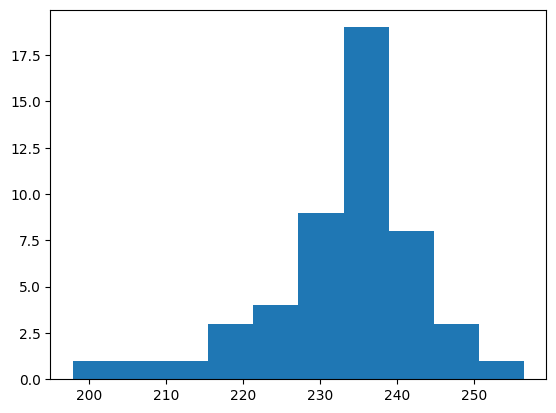

In [41]:
plt.hist(tiempos["Dijkstra"])
plt.show()

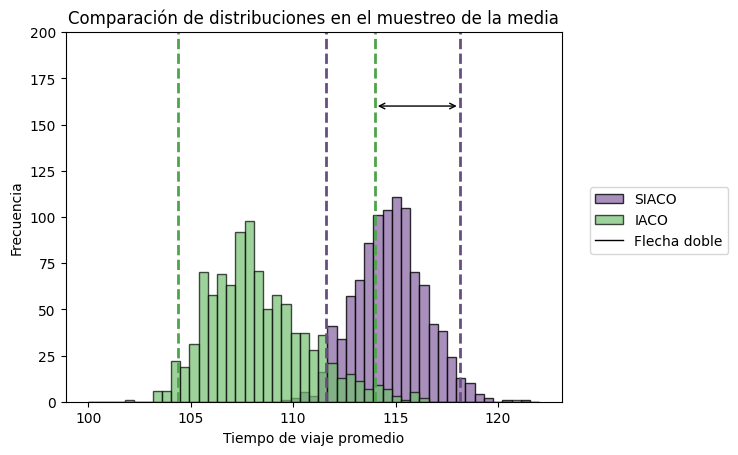

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Generar datos aleatorios para los dos histogramas
siaco = bootstrap_means_siaco
iaco = bootstrap_means_iaco
percentil_95_siaco = np.percentile(siaco, 97.5)
percentil_95_iaco = np.percentile(iaco, 97.5)
percentil_5_siaco = np.percentile(siaco, 2.5)
percentil_5_iaco = np.percentile(iaco, 2.5)

# Crear el histograma
bins = np.linspace(100, 122, 50)  # Definir los límites y el número de bins

# Crear los histogramas superpuestos
plt.hist(siaco, bins=bins, alpha=0.8, label='SIACO', color='#9475AB', edgecolor='black')
plt.hist(iaco, bins=bins, alpha=0.7, label='IACO', color='#75BF71', edgecolor='black')

plt.axvline(percentil_95_siaco, color='#6A4D7F', linestyle='dashed', linewidth=2)
plt.axvline(percentil_95_iaco, color='#4EA44A', linestyle='dashed', linewidth=2)
plt.axvline(percentil_5_siaco, color='#6A4D7F', linestyle='dashed', linewidth=2)
plt.axvline(percentil_5_iaco, color='#4EA44A', linestyle='dashed', linewidth=2)

mid_point = (percentil_95_iaco + percentil_95_siaco) / 2
plt.annotate(
    '', 
    xy=(percentil_95_iaco, 160), 
    xytext=(percentil_95_siaco, 160),
    arrowprops=dict(arrowstyle='<->', color='black')
)
# plt.text(mid_point, 162, 'Distancia entre P95', ha='center', va='bottom', color='black')

# Obtener la leyenda actual
handles, labels = plt.gca().get_legend_handles_labels()

# Crear una línea con flecha doble para agregar a la leyenda
arrow_line = plt.Line2D([0, 1], [0, 0], color='black', linestyle='-', linewidth=1, marker=None)
arrow_line.set_clip_on(False)

# Añadir la nueva entrada a la leyenda
handles.append(arrow_line)
labels.append('Flecha doble')

# Mostrar la leyenda
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.35, 0.6))

plt.ylim(0, 200)

# Añadir etiquetas y título
plt.xlabel('Tiempo de viaje promedio')
plt.ylabel('Frecuencia')
plt.title('Comparación de distribuciones en el muestreo de la media')


# Mostrar el gráfico
plt.show()


In [32]:
bootstrap_means_siaco

array([117.93660175, 111.82513073, 114.03426925, 113.94114065,
       114.36510397, 114.75830749, 116.86567734, 115.70787349,
       116.08329594, 115.26828006, 115.47224559, 117.32979184,
       112.65717008, 115.23292558, 115.35616273, 115.74581901,
       115.26395457, 115.61343719, 115.35318945, 114.93840759,
       116.13358665, 113.71792728, 113.83936373, 113.86755726,
       118.81313947, 115.40022205, 117.12890965, 114.86137793,
       118.32346152, 115.21901053, 114.95543781, 116.45273976,
       116.22509514, 118.88637367, 114.21864942, 116.43881218,
       115.90633294, 115.01879373, 114.82549312, 112.95197953,
       114.67178804, 115.4552301 , 113.55895391, 115.49134936,
       113.72807008, 116.30248389, 114.27379827, 111.49945533,
       113.33946917, 112.36988021, 117.18720272, 115.82798002,
       116.05255266, 113.23464412, 114.53993038, 111.94526828,
       114.87674512, 113.42167821, 112.173013  , 112.23817406,
       114.75809683, 112.68670831, 111.82128562, 117.64

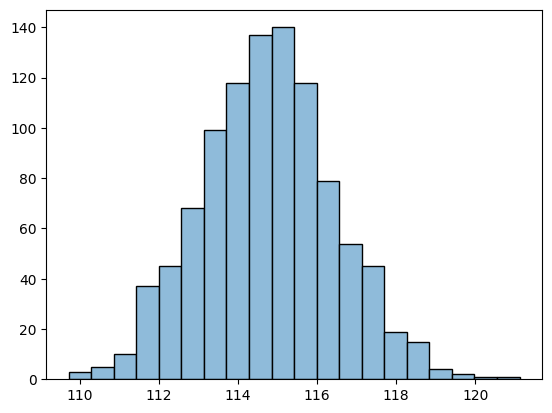

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generar datos aleatorios de una distribución normal
data = bootstrap_means_siaco

# Crear el histograma
n, bins, patches = plt.hist(data, bins=20, edgecolor='black')

# Definir el color base
base_color = "#1f77b4"  # Azul

# Crear un colormap personalizado con degradado
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [base_color, "white"])

# Aplicar el degradado a cada barra
for patch in patches:
    # Crear un degradado en cada barra
    path = patch.get_path()
    verts = path.vertices
    verts = np.vstack([verts, verts[-2]])  # Añadir el último vértice para cerrar el path
    gradient = np.linspace(0, 1, 256).reshape(256, 1)
    gradient = np.repeat(gradient, 4, axis=1)

    # Crear un array de colores
    colors = cmap(gradient)[:, 0, :]

    # Crear el PathPatch con el degradado
    patch.set_facecolor(colors[128])
    patch.set_edgecolor('black')

plt.show()


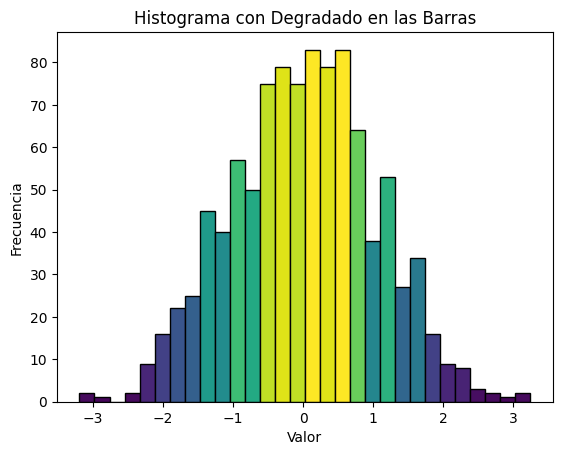

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

# Generar datos aleatorios
data = np.random.randn(1000)

# Crear el histograma
n, bins, patches = plt.hist(data, bins=30, edgecolor='black')

# Crear un gradiente de color
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(min(n), max(n))

# Aplicar el gradiente a cada barra
for bin_start, bin_end, patch in zip(bins[:-1], bins[1:], patches):
    bin_height = patch.get_height()
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    # Crear un gradiente de color para cada barra
    patch.set_facecolor(cmap(norm(bin_height)))

# Mostrar el gráfico
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma con Degradado en las Barras')
plt.show()


In [22]:
mean(siaco_batch.veh_global_stats["time"]), mean(iaco_batch.veh_global_stats["time"])

(114.77082112453179, 108.26161470740537)

AttributeError: Rectangle.set() got an unexpected keyword argument 'opacity'

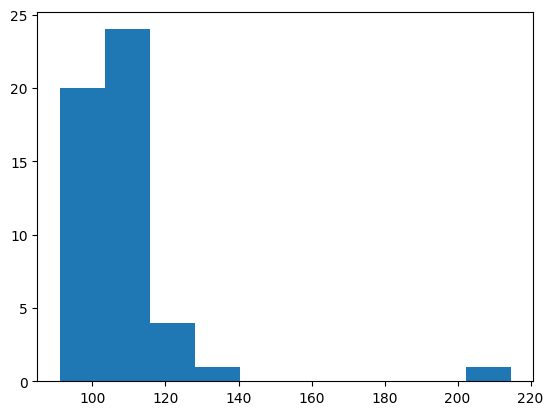

In [22]:
plt.hist(tiempos["IACO"])
plt.show()

In [26]:
import numpy as np
import scipy.stats as stats

# Datos de muestra
muestra = tiempos["IACO"]

# Parámetros
n_bootstrap = 1000  # Número de muestras bootstrap
alpha = 0.05  # Nivel de significancia

# Generar muestras bootstrap y calcular medias
bootstrap_means_iaco = np.array([np.mean(np.random.choice(muestra, size=len(muestra), replace=True)) for _ in range(n_bootstrap)])

# Calcular percentiles para el intervalo de confianza
lower_bound = np.percentile(bootstrap_means_iaco, 100 * (alpha/2))
upper_bound = np.percentile(bootstrap_means_iaco, 100 * (1 - alpha/2))

# Media muestral
media_muestral_iaco = np.mean(muestra)

# Resultado
print(f"Intervalo de confianza del {100 * (1 - alpha)}%: ({lower_bound}, {upper_bound})")
print(f"Media muestral: {media_muestral_iaco}")


Intervalo de confianza del 95.0%: (104.37363583034261, 113.99266206758284)
Media muestral: 108.26161470740539


In [148]:
import numpy as np
import scipy.stats as stats

# Datos de muestra
muestra = tiempos["SIACO"]

# Parámetros
n_bootstrap = 9999  # Número de muestras bootstrap
alpha = 0.05  # Nivel de significancia

# Generar muestras bootstrap y calcular medias
# bootstrap_means = []
# for _ in range(n_bootstrap):
#     resample = np.random.choice(muestra, size=len(muestra), replace=True)
#     stat = np.mean(resample)/(np.std(resample)/np.sqrt(len(resample)))
#     bootstrap_means_siaco2.append(stat)
bootstrap_means_siaco = np.array([np.mean(np.random.choice(muestra, size=len(muestra), replace=True)) for _ in range(n_bootstrap)])
bootstrap_means= np.array([np.mean(np.random.choice(tiempos["SIACO"], size=len(tiempos["SIACO"]), replace=True)) - np.mean(np.random.choice(tiempos["IACO"], size=len(tiempos["IACO"]), replace=True)) for _ in range(n_bootstrap)])

# Calcular percentiles para el intervalo de confianza
lower_bound = np.percentile(bootstrap_means, 100 * (alpha/2))
upper_bound = np.percentile(bootstrap_means, 100 * (1 - alpha/2))

# Media muestral
media_muestral_siaco = np.mean(bootstrap_means_siaco)
media_muestral_siaco2 = np.mean(bootstrap_means_siaco2)

# Resultado
print(f"Intervalo de confianza del {100 * (1 - alpha)}%: ({lower_bound}, {upper_bound})")
print(f"Media muestral: {media_muestral_siaco}")
print(f"Media muestral2: {media_muestral_siaco2}")

Intervalo de confianza del 95.0%: (0.3543736034272414, 12.053987827705267)
Media muestral: 114.75783549508583
Media muestral2: 67.8650528986506


In [119]:
bootstrap_means_siaco2.sort()
bootstrap_means_siaco2[int(len(bootstrap_means_siaco2)*0.025)]*np.std(bootstrap_means_siaco2)/np.sqrt(len(bootstrap_means_siaco2))+np.mean(bootstrap_means_siaco2)

72.72404610337499

In [126]:
np.std(bootstrap_means_siaco2)
np.sqrt(len(bootstrap_means_siaco2))
bootstrap_means_siaco2[int(len(bootstrap_means_siaco2)*0.025)]
# int(len(bootstrap_means_siaco2)*0.025)


54.29954229300105

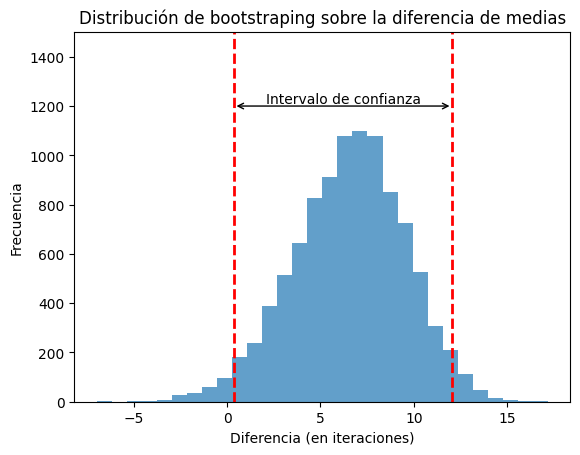

In [162]:
plt.hist(bootstrap_means, bins=30, alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2)
plt.title("Distribución de bootstraping sobre la diferencia de medias")
plt.ylim(top=1500)
plt.xlabel("Diferencia (en iteraciones)")
plt.ylabel("Frecuencia")
mid_point = (lower_bound + upper_bound) / 2
plt.annotate(
    '', 
    xy=(lower_bound, 1200), 
    xytext=(upper_bound, 1200),
    arrowprops=dict(arrowstyle='<->', color='black')
)
plt.text(mid_point, 1200, 'Intervalo de confianza', ha='center', va='bottom', color='black')

plt.show()

# Visualizaciones

C:\Users\colla\AppData\Local\Temp\ipykernel_21764\2654822939.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df.Value, y=df.Category, palette="muted")


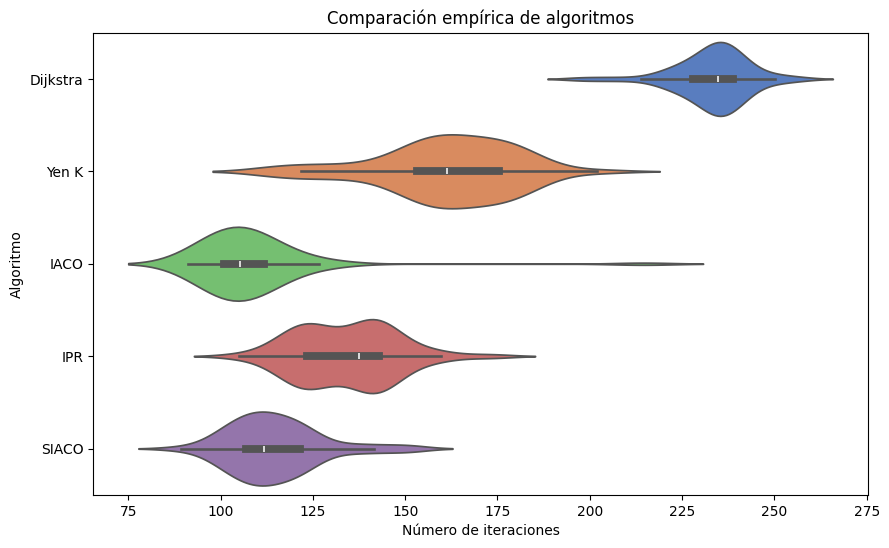

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datos de ejemplo
data_dict = tiempos

# Convertir el diccionario en un DataFrame
data = []
for category, values in data_dict.items():
    for value in values:
        data.append((category, value))

df = pd.DataFrame(data, columns=['Category', 'Value'])

# Crear diagrama de violín
plt.figure(figsize=(10, 6))
sns.violinplot(x=df.Value, y=df.Category, palette="muted")
plt.title('Comparación empírica de algoritmos')
plt.xlabel('Número de iteraciones')
plt.ylabel('Algoritmo')
plt.show()

# sns.violinplot(
#     x     = datos.total_spend,
#     y     = datos.city_tier,
#     color = ".8",
#     ax    = axs[0]
# )


In [ ]:
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
sns.violinplot(
    x     = datos.total_spend,
    y     = datos.city_tier,
    color = ".8",
    ax    = axs[0]
)

In [164]:
np.mean(tiempos["SIACO"])

114.77082112453179